In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("csv_Conversion/precipitationDATA.csv")
data.head()

,Datatime,nlat,elon,Precipitation,HQprecipitation,IRprecipitation,randomError
0,1998_1_1_12,-179.875,-20.625,6.150000,0.03,7.62,27.433357
1,1998_1_1_12,-179.875,-20.375,8.879999,0.17999999,9.21,33.836193
2,1998_1_1_12,-179.875,-19.625,2.130000,0,3.9299998,12.390074
3,1998_1_1_12,-179.875,-19.375,6.420000,0,7.56,28.998985
4,1998_1_1_12,-179.875,-19.125,17.579998,0.06,20.19,63.292313


In [3]:
any_nan = data.isna().any().any()
print(any_nan)

False


In [4]:
data_training = data.iloc[:,3:].copy()

In [5]:
data_training_ = data_training.replace('--', 0)
data_training__ = data_training_.applymap(lambda x: pd.to_numeric(x, errors='coerce'))
data_training__ = data_training__.dropna()
data_training_cleaned = data_training__.copy()  # Assuming this is your training set

C:\Users\Dell\AppData\Local\Temp\ipykernel_4092\2577119532.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_training__ = data_training_.applymap(lambda x: pd.to_numeric(x, errors='coerce'))


In [6]:
data_training_cleaned

,Precipitation,HQprecipitation,IRprecipitation,randomError
0,6.150000,0.03,7.620000,27.433357
1,8.879999,0.18,9.210000,33.836193
2,2.130000,0.00,3.930000,12.390074
3,6.420000,0.00,7.560000,28.998985
4,17.579998,0.06,20.190000,63.292313
...,...,...,...,...
107658,17.640000,0.09,19.529999,63.374893
107659,14.370000,0.09,16.410000,54.504913
107660,3.840000,0.24,4.470000,20.348846
107661,8.160000,0.15,9.599999,35.795483


In [11]:
X = data_training_cleaned[['Precipitation', 'HQprecipitation', 'IRprecipitation', 'randomError']]
y = data_training_cleaned[['Precipitation', 'HQprecipitation', 'IRprecipitation']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (86130, 4)
X_test: (21533, 4)
y_train: (86130, 3)
y_test: (21533, 3)


In [14]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [15]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [16]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)  # Output layer with 3 neurons for Precipitation, HQprecipitation, IRprecipitation
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
model = ANN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
batch_size = 32

In [22]:
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        optimizer.zero_grad()
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(X_train_tensor):.4f}")

Epoch 1/10, Training Loss: 2.1384
Epoch 2/10, Training Loss: 0.1004
Epoch 3/10, Training Loss: 0.0076
Epoch 4/10, Training Loss: 0.0014
Epoch 5/10, Training Loss: 0.0004
Epoch 6/10, Training Loss: 0.0002
Epoch 7/10, Training Loss: 0.0001
Epoch 8/10, Training Loss: 0.0001
Epoch 9/10, Training Loss: 0.0001
Epoch 10/10, Training Loss: 0.0001


In [23]:
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print("Test Loss:", test_loss.item())

Test Loss: 0.001257240423001349


In [24]:
torch.save(model.state_dict(), "ANN_RE_model.pt")


In [25]:
with torch.no_grad():
    predictions = model(X_test_tensor)
    print("Predicted values:")
    print(predictions)

Predicted values:
tensor([[ 2.5329,  1.6317, 11.2226],
        [ 6.5798,  3.2197,  3.3009],
        [ 2.8870, -0.0189,  2.8513],
        ...,
        [ 4.8515, -0.0195,  5.0116],
        [ 2.9179,  0.8514,  3.5712],
        [ 4.0928,  2.9506,  5.6114]])


In [18]:
y_pred_numpy = predictions.numpy()
y_test_numpy = y_test_tensor.numpy()

NameError: name 'predictions' is not defined

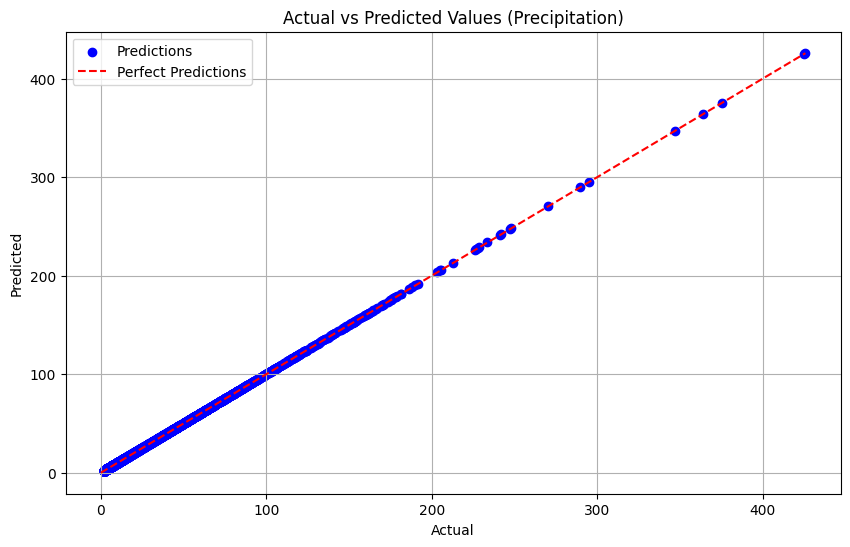

In [27]:
# Choose the index of the target variable you want to plot (0 for Precipitation, 1 for HQprecipitation, 2 for IRprecipitation)
target_index = 0
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numpy[:, target_index], y_pred_numpy[:, target_index], color='blue', label='Predictions')
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], color='red', linestyle='--', label='Perfect Predictions')
plt.title('Actual vs Predicted Values (Precipitation)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

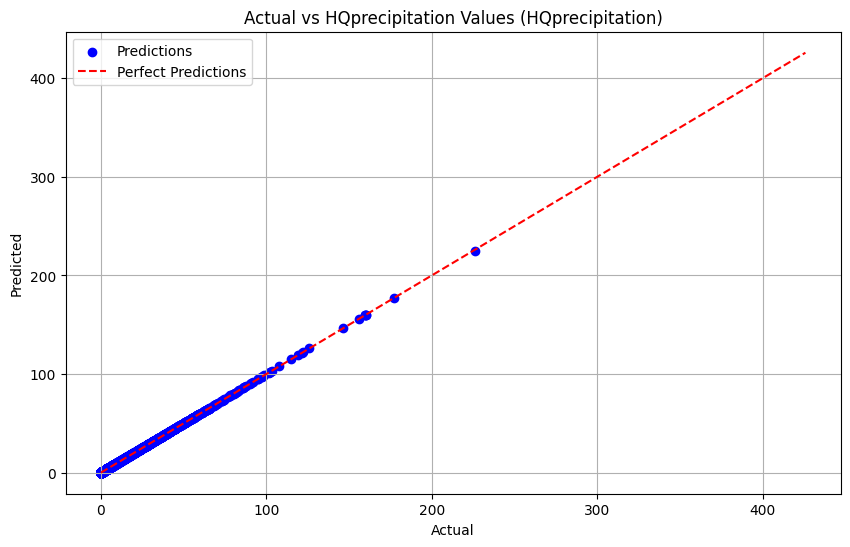

In [28]:
target_index = 1
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numpy[:, target_index], y_pred_numpy[:, target_index], color='blue', label='Predictions')
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], color='red', linestyle='--', label='Perfect Predictions')
plt.title('Actual vs HQprecipitation Values (HQprecipitation)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

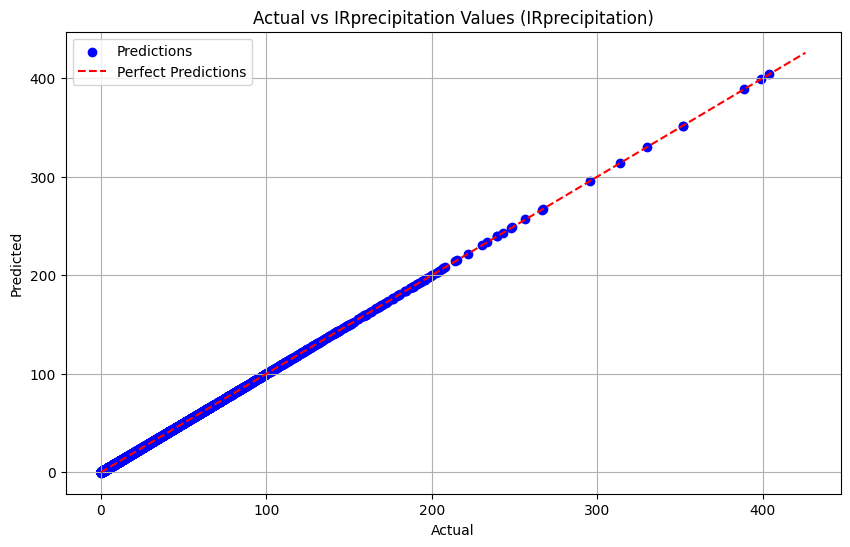

In [29]:
target_index = 2
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numpy[:, target_index], y_pred_numpy[:, target_index], color='blue', label='Predictions')
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], color='red', linestyle='--', label='Perfect Predictions')
plt.title('Actual vs IRprecipitation Values (IRprecipitation)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
data2 = data_training_cleaned[['Precipitation', 'HQprecipitation', 'IRprecipitation']]

In [20]:
X1 = data_training_cleaned[['Precipitation', 'HQprecipitation', 'IRprecipitation']]
y1 = data_training_cleaned[['Precipitation']]

In [21]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [22]:
print("X_train:", X_train1.shape)
print("X_test:", X_test1.shape)
print("y_train:", y_train1.shape)
print("y_test:", y_test1.shape)

X_train: (86130, 3)
X_test: (21533, 3)
y_train: (86130, 1)
y_test: (21533, 1)


In [23]:
X_train_normalized1 = scaler.fit_transform(X_train1)
X_test_normalized1 = scaler.transform(X_test1)

In [24]:
X_train_tensor1 = torch.tensor(X_train_normalized1, dtype=torch.float32)
X_test_tensor1 = torch.tensor(X_test_normalized1, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y_train1.values, dtype=torch.float32)
y_test_tensor1 = torch.tensor(y_test1.values, dtype=torch.float32)

In [26]:
class ANN_2(nn.Module):
    def __init__(self):
        super(ANN_2, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer with 3 neurons for Precipitation, HQprecipitation, IRprecipitation
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
model2 = ANN_2()

criterion = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

epochs = 10
batch_size = 16

In [48]:
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train_tensor1), batch_size):
        optimizer2.zero_grad()
        batch_X1 = X_train_tensor1[i:i+batch_size]
        batch_y1 = y_train_tensor1[i:i+batch_size]
        outputs1 = model2(batch_X1)
        loss1 = criterion(outputs1, batch_y1)
        loss1.backward()
        nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer2.step()
        epoch_loss += loss1.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(X_train_tensor1):.4f}")

Epoch 1/10, Training Loss: 2.4364
Epoch 2/10, Training Loss: 0.0013
Epoch 3/10, Training Loss: 0.0010
Epoch 4/10, Training Loss: 0.0008
Epoch 5/10, Training Loss: 0.0007
Epoch 6/10, Training Loss: 0.0007
Epoch 7/10, Training Loss: 0.0007
Epoch 8/10, Training Loss: 0.0006
Epoch 9/10, Training Loss: 0.0006
Epoch 10/10, Training Loss: 0.0005


In [49]:
with torch.no_grad():
    y_pred1 = model2(X_test_tensor1)
    test_loss1 = criterion(y_pred1, y_test_tensor1)
    print("Test Loss:", test_loss1.item())

Test Loss: 0.02676575630903244


In [50]:
torch.save(model2.state_dict(), "ANN_pre_model.pt")

In [51]:
with torch.no_grad():
    predictions1 = model2(X_test_tensor1)
    print("Predicted values:")
    print(predictions1)

Predicted values:
tensor([[2.3533],
        [6.4025],
        [2.7206],
        ...,
        [4.6789],
        [2.7493],
        [3.9168]])


In [52]:
y_pred_numpy1 = predictions1.numpy()
y_test_numpy1 = y_test_tensor1.numpy()

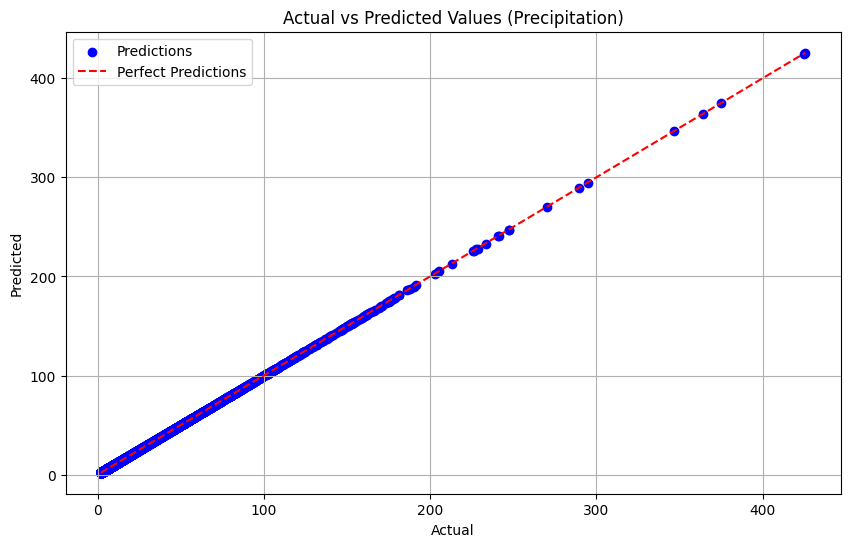

In [53]:
target_index = 0
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numpy1[:, target_index], y_pred_numpy1[:, target_index], color='blue', label='Predictions')
plt.plot([y_test_numpy1.min(), y_test_numpy1.max()], [y_test_numpy1.min(), y_test_numpy1.max()], color='red', linestyle='--', label='Perfect Predictions')
plt.title('Actual vs Predicted Values (Precipitation)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
original_precipatation = data['Precipitation']
original_precipatation = original_precipatation.to_numpy()
original_precipatation

array([6.1499996, 8.879999 , 2.1299999, ..., 3.84     , 8.16     ,
       2.58     ])

In [29]:
len(original_precipatation)

107663

In [30]:
X

,Precipitation,HQprecipitation,IRprecipitation,randomError
0,6.150000,0.03,7.620000,27.433357
1,8.879999,0.18,9.210000,33.836193
2,2.130000,0.00,3.930000,12.390074
3,6.420000,0.00,7.560000,28.998985
4,17.579998,0.06,20.190000,63.292313
...,...,...,...,...
107658,17.640000,0.09,19.529999,63.374893
107659,14.370000,0.09,16.410000,54.504913
107660,3.840000,0.24,4.470000,20.348846
107661,8.160000,0.15,9.599999,35.795483


In [31]:
model.load_state_dict(torch.load("ANN_RE_model.pt"))
model.eval()

ANN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [32]:
X_np = X.to_numpy()

scaler = MinMaxScaler()
X_np_normalized = scaler.fit_transform(X_np)

input_tensor = torch.tensor(X_np_normalized, dtype=torch.float32) 
with torch.no_grad():
    predictions = model(input_tensor)

print("Predictions:")
print(predictions)


Predictions:
tensor([[ 6.1911e+00,  5.8074e-03,  7.6222e+00],
        [ 8.9229e+00,  1.3534e-01,  9.2124e+00],
        [ 2.1712e+00, -1.8389e-02,  3.9305e+00],
        ...,
        [ 3.8785e+00,  1.8961e-01,  4.4715e+00],
        [ 8.2029e+00,  1.0924e-01,  9.6026e+00],
        [ 2.6200e+00,  3.3562e-02,  7.4421e+00]])


In [33]:
precipatation_ANN_model1 = predictions
ANN_RE = []
for i in precipatation_ANN_model1:
    ANN_RE.append(i[0].tolist())

In [34]:
ANN_RE

[6.191056251525879,
 8.922895431518555,
 2.171236276626587,
 6.461075305938721,
 17.6320743560791,
 18.57195472717285,
 9.531892776489258,
 2.7670536041259766,
 5.049125671386719,
 6.010119438171387,
 7.331385612487793,
 3.189335346221924,
 2.7370243072509766,
 2.287339448928833,
 3.2781543731689453,
 6.130399703979492,
 7.421385288238525,
 8.863268852233887,
 5.109974384307861,
 3.098433256149292,
 7.842037677764893,
 15.61897087097168,
 26.39845085144043,
 15.50002670288086,
 19.976903915405273,
 16.760257720947266,
 21.715423583984375,
 35.7974853515625,
 22.584054946899414,
 17.71985626220703,
 30.5096378326416,
 23.935373306274414,
 20.241504669189453,
 18.200334548950195,
 18.980527877807617,
 10.334287643432617,
 3.998377561569214,
 3.518662691116333,
 2.406846284866333,
 2.64697003364563,
 2.06369948387146,
 3.9393770694732666,
 7.211790084838867,
 17.901735305786133,
 16.88050079345703,
 40.57240295410156,
 24.058408737182617,
 21.929779052734375,
 42.32499694824219,
 35.58975

In [35]:
len(ANN_RE)

107663

In [36]:
model2.load_state_dict(torch.load("ANN_pre_model.pt"))
model2.eval()

ANN_2(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [37]:

X1 = data_training_cleaned[['Precipitation', 'HQprecipitation', 'IRprecipitation']]

Xnp1 = X1.to_numpy()

scaler = MinMaxScaler()
Xnp1_normalized = scaler.fit_transform(Xnp1)

input_tensor1 = torch.tensor(Xnp1_normalized, dtype=torch.float32) 
with torch.no_grad():
    predictions1 = model2(input_tensor1)

ANN_pre = []
for j in predictions1:
    ANN_pre.append(j[0].tolist())
    

In [38]:
ANN_pre

[6.012623310089111,
 8.737592697143555,
 2.019519567489624,
 6.282325744628906,
 17.417463302612305,
 18.33274269104004,
 9.324129104614258,
 2.6010336875915527,
 4.876147270202637,
 5.833100318908691,
 7.149575710296631,
 3.0171635150909424,
 2.57059383392334,
 2.1235814094543457,
 3.1087865829467773,
 5.952909469604492,
 7.240504264831543,
 8.676687240600586,
 4.934529781341553,
 2.928575038909912,
 7.658817768096924,
 15.412158966064453,
 26.159486770629883,
 15.290234565734863,
 19.74651527404785,
 16.547636032104492,
 21.486085891723633,
 35.527809143066406,
 22.358299255371094,
 17.509164810180664,
 30.26177978515625,
 23.70565414428711,
 20.023759841918945,
 17.987550735473633,
 18.76596450805664,
 10.142780303955078,
 3.827543258666992,
 3.348313093185425,
 2.24165940284729,
 2.481288194656372,
 1.9292787313461304,
 3.766960859298706,
 7.030710697174072,
 17.68783187866211,
 16.670366287231445,
 40.28977584838867,
 23.823348999023438,
 21.6937255859375,
 42.01249313354492,
 35.

In [39]:
len(ANN_pre)

107663

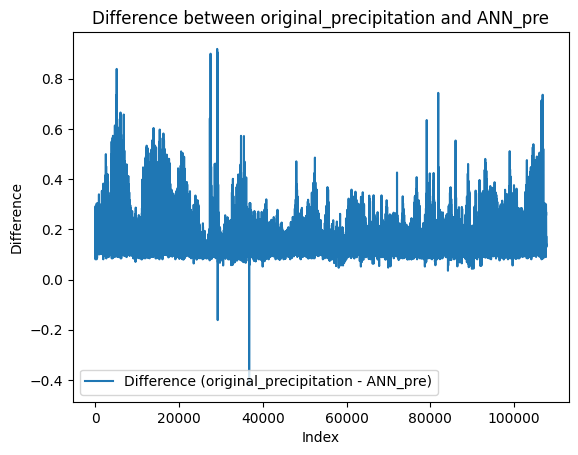

In [156]:
difference = [original - pre for original, pre in zip(original_precipatation, ANN_pre)]

# Plotting the difference
plt.plot(difference, label='Difference (original_precipitation - ANN_pre)')

# Adding legend
plt.legend()

# Adding labels
plt.xlabel('Index')
plt.ylabel('Difference')

# Adding title
plt.title('Difference between original_precipitation and ANN_pre')

# Displaying the plot
plt.show()

C:\Users\Dell\anaconda3\envs\rain_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


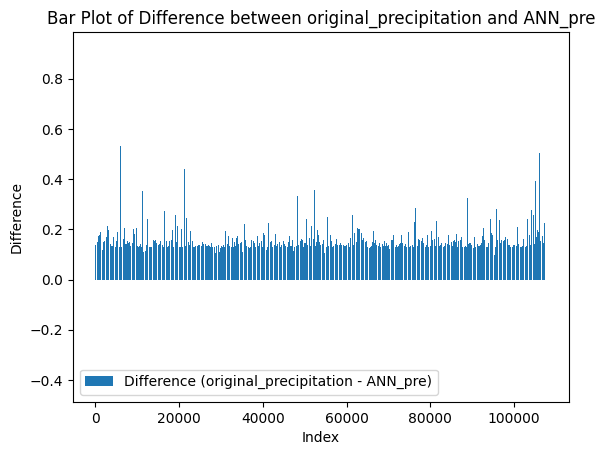

In [158]:
import matplotlib.pyplot as plt

# Assuming you have lists named original_precipitation and ANN_pre
# Modify these lists with your actual data

# Calculate the difference between original_precipitation and ANN_pre
difference = [original - pre for original, pre in zip(original_precipatation, ANN_pre)]

# Create a bar plot of the differences
plt.bar(range(len(difference)), difference, label='Difference (original_precipitation - ANN_pre)')

# Adding legend
plt.legend()

# Adding labels
plt.xlabel('Index')
plt.ylabel('Difference')

# Adding title
plt.title('Bar Plot of Difference between original_precipitation and ANN_pre')

# Displaying the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(original_precipatation))

width = 0.25

plt.bar(x - width, original_precipatation, width=width, label='original_precipitation', alpha=0.5)

plt.bar(x, ANN_RE, width=width, label='ANN_RE', alpha=0.5)

plt.bar(x + width, ANN_pre, width=width, label='ANN_pre', alpha=0.5)

plt.legend()

plt.xlabel('Index')
plt.ylabel('Values')

plt.title('Bar Plot of Three Lists with Emphasized ANN_pre')

plt.xticks(x, [str(i) for i in range(len(original_precipatation))])

plt.show()
